In [1]:
!pip install openpyxl

In [2]:
import mlfinlab
import pandas as pd
import numpy as np
import random
import yfinance as yf
from mlfinlab.portfolio_optimization.tic import TIC
from datetime import datetime, timedelta
import pypfopt
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns,plotting,objective_functions
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from datetime import datetime,date
import calendar


In [3]:
def monthdelta(date, delta):
    m, y = (date.month+delta) % 12, date.year + ((date.month)+delta-1) // 12
    if not m: m = 12
    d = min(date.day, [31,
        29 if y%4==0 and (not y%100==0 or y%400 == 0) else 28,
        31,30,31,30,31,31,30,31,30,31][m-1])
    return date.replace(day=d,month=m, year=y)

In [4]:
europe_tickers = ["0P0000P1BG.F", "EXSA.DE", "0P00000RNA.F"]
#data_eur = yf.download(" ".join(europe_tickers),period="max")
#data_eur= data_eur["Adj Close"]
#currency_eur = yf.download(" ".join([ "EURUSD=X "]), period = "max")
#currency_eur = currency_eur["Adj Close"]
#

In [5]:
#for ticker in europe_tickers:
#    data_eur[ticker] = data_eur[ticker] * currency_eur


In [6]:
portfolio_tickers = ["SPY", "LQD", "TLT"]

#data_opt = yf.download(" ".join(portfolio_tickers),period="max")
#
#data_opt = data_opt["Adj Close"]
#for ticker in europe_tickers:
#    data_opt[ticker] = data_eur[ticker]
#

In [7]:
#data_opt.to_excel(r"C:\Users\Vannesa Nyathi\OneDrive - University of Bristol\MDM3\MDM3.xlsx", index = True)

In [8]:
path = (r"C:\Users\Vannesa Nyathi\OneDrive - University of Bristol\MDM3\MDM3.xlsx")
data_final = pd.read_excel(path,index_col = "Date")


In [9]:
def tic_covariances(data_opt):
    
    #Country tree
    data2 = {"Ticker": ["TLT","SPY","LQD","0P0000P1BG.F", "EXSA.DE", "0P00000RNA.F"],
        "Country":[115,115,115,125,125,125],
       "Structure":[1,1,1,1,1,1]}
    df2 = pd.DataFrame(data2)
    
    
    #Asset type tree
    data = {"Ticker": ["TLT","SPY","LQD","0P0000P1BG.F", "EXSA.DE", "0P00000RNA.F"],
        "Asset Class":[215,225,235,215,225,235],
       "Structure":[2,2,2,2,2,2]}
    
    df = pd.DataFrame(data)
    

    
    stock_returns = expected_returns.mean_historical_return(data_opt, frequency = len(data_opt))
    daily_returns = expected_returns.returns_from_prices(data_opt, log_returns=False)
    
    std_ticker = []
    for key in range(stock_returns.shape[0]):
        std_ticker.append(daily_returns.iloc[:, key].std())
    corr_matrix = daily_returns.corr()
    tn_relation = daily_returns.shape[0] / daily_returns.shape[1]
    
    tic = TIC()
    tic_matrix = pd.DataFrame(tic.tic_correlation(df, corr_matrix, tn_relation, kde_bwidth=0.01))
    matrix_distance = tic.corr_dist(corr_matrix, tic_matrix)
    tic_cov = pypfopt.risk_models.corr_to_cov(tic_matrix,std_ticker)*len(data_opt)
    
    
    tic2 = TIC()
    tic_matrix_2 = pd.DataFrame(tic2.tic_correlation(df2, corr_matrix, tn_relation, kde_bwidth=0.01))
    matrix_distance2 = tic2.corr_dist(corr_matrix, tic_matrix_2)
    tic_cov2 = pypfopt.risk_models.corr_to_cov(tic_matrix_2,std_ticker)*len(data_opt)
    
    big_tic = (tic_matrix+tic_matrix_2)/2
    big_tic_cov = pypfopt.risk_models.corr_to_cov(big_tic,std_ticker)*len(data_opt)
    
    empirical_covariance = risk_models.sample_cov(data_opt, frequency=len(data_opt))
    
    return big_tic_cov, tic_cov, tic_cov2, empirical_covariance



In [10]:
def optimisation(data_opt, covariance,target_volatility):
    cleaned_weights = {}
    
    # Calculate the expected returns and covariance matrix based on that month
    mu = expected_returns.mean_historical_return(data_opt)
    S = tic_covariances(data_opt)[covariance]
    # Optimise mean - variance to get weights for initialising investment process
    ef = EfficientFrontier(mu, S)
    #ef.add_objective(objective_functions.L2_reg, gamma = 1)
    #print(np.sqrt(np.abs(1 / np.sum(np.linalg.inv(S)))))
    try:
        raw_weights = ef.efficient_risk(target_volatility)
    except:
        raw_weights =  ef.efficient_risk(np.sqrt(np.abs(1 / np.sum(np.linalg.inv(S)))))
    cleaned_weights = ef.clean_weights()
    return cleaned_weights

In [11]:
def fractional_profit(cleaned_weights,portfolio_value_updated,i,start_date,data,interval):
    monthly_earnings = 0
    j=0
    for key in cleaned_weights:
        nb_shares =(portfolio_value_updated/get_latest_prices(data.loc[:monthdelta(start_date, i+interval)])[j])
        price_diff = (get_latest_prices(data.loc[:monthdelta(start_date, i+2*interval)])[j] -get_latest_prices(data.loc[:monthdelta(start_date, i+interval)])[j])
        monthly_earnings += cleaned_weights[str(key)]*nb_shares *price_diff
        j = j +1
    return monthly_earnings


In [12]:
def investment_simulation(data, start_date, end_date, covariance, portfolio_value=1000000, interval=1):
    i = -interval
    portfolio_value_updated = portfolio_value
    total_profit = 0
    monthly_profit = 0
    timer = True
    cleaned_weights = {}
    profit_values = []
    month_values = []
    cum_portfolio_value = []
    actual_returns = []
    actual_risk = []
    weights_list = []
    while timer:
        try:
            cleaned_weights = optimisation(data.loc[monthdelta(start_date,i):monthdelta(start_date,i+interval)],covariance, 0.155)
            S = tic_covariances(data.loc[monthdelta(start_date,i):monthdelta(start_date,i+interval)])[covariance]
        except:
            S = 0
            for element in data.keys():
                cleaned_weights[element] = 1/data.shape[1]
        monthly_profit = fractional_profit(cleaned_weights,portfolio_value_updated,i,start_date,data,interval)
        cleaned_weights_array = np.array(list(cleaned_weights.values()))
        
        
        #current_data_opt = data.loc[monthdelta(start_date,i):monthdelta(start_date,i+interval)]
        #mu = expected_returns.mean_historical_return(current_data_opt, frequency = len(current_data_opt))
        #expected_return.append(np.dot(mu, cleaned_weights_array).sum())
        
        var = np.dot(cleaned_weights_array.T, np.dot(S, cleaned_weights_array))
        actual_risk.append(np.sqrt(var)*100)
        weights_list.append(cleaned_weights_array)
      
        month_values.append((i))
        profit_values.append((monthly_profit/portfolio_value)*100)
        cum_portfolio_value.append(portfolio_value_updated)
        #actual_returns.append(monthly_profit/np.sum(cum_portfolio_value))
        actual_returns.append((monthly_profit/portfolio_value_updated)*100)
        portfolio_value_updated += monthly_profit
        i +=interval
        if monthdelta(start_date,i) == end_date:
            total_profit = portfolio_value_updated - portfolio_value
            timer = False

    return total_profit, profit_values, month_values, cum_portfolio_value, actual_returns, actual_risk, weights_list


In [13]:
#New data set
old_data = data_final.drop("0P00000RNA.F",1)
old_data.tail()

,LQD,SPY,TLT,0P0000P1BG.F,EXSA.DE
Date,,,,,
2020-11-20,137.570007,355.329987,161.509995,28.453441,45.739336
2020-11-23,137.740005,357.459991,160.770004,28.448695,45.626608
2020-11-24,137.429993,363.220001,159.169998,28.397680,46.003082
2020-11-25,137.509995,362.660004,158.679993,28.545758,46.179937
2020-11-27,138.000000,363.670013,160.220001,NaN,46.394937


In [14]:
def tic_covariances_2(data_opt):
    
    #Country tree
    #Country tree
    data2 = {"Ticker": ["TLT","SPY","LQD","0P0000P1BG.F", "EXSA.DE"],
        "Country":[115,115,115,125,125],
       "Structure":[1,1,1,1,1]}
    df2 = pd.DataFrame(data2)
    
    
    #Asset type tree
    data = {"Ticker": ["TLT","SPY","LQD","0P0000P1BG.F", "EXSA.DE"],
        "Asset Class":[215,225,235,215,225],
       "Structure":[2,2,2,2,2],}
    df = pd.DataFrame(data)

    stock_returns = expected_returns.mean_historical_return(data_opt, frequency = len(data_opt))
    daily_returns = expected_returns.returns_from_prices(data_opt, log_returns=False)
    
    std_ticker = []
    for key in range(stock_returns.shape[0]):
        std_ticker.append(daily_returns.iloc[:, key].std())
    corr_matrix = daily_returns.corr()
    tn_relation = daily_returns.shape[0] / daily_returns.shape[1]
    
    tic = TIC()
    tic_matrix = pd.DataFrame(tic.tic_correlation(df, corr_matrix, tn_relation, kde_bwidth=0.01))
    matrix_distance = tic.corr_dist(corr_matrix, tic_matrix)
    tic_cov = pypfopt.risk_models.corr_to_cov(tic_matrix,std_ticker)*len(data_opt)
    
    
    tic2 = TIC()
    tic_matrix_2 = pd.DataFrame(tic2.tic_correlation(df2, corr_matrix, tn_relation, kde_bwidth=0.01))
    matrix_distance2 = tic2.corr_dist(corr_matrix, tic_matrix_2)
    tic_cov2 = pypfopt.risk_models.corr_to_cov(tic_matrix_2,std_ticker)*len(data_opt)
    
    big_tic = (tic_matrix+tic_matrix_2)/2
    big_tic_cov = pypfopt.risk_models.corr_to_cov(big_tic,std_ticker)*len(data_opt)
    
    empirical_covariance = risk_models.sample_cov(data_opt, frequency = len(data_opt))
    
    return big_tic_cov, tic_cov, tic_cov2, empirical_covariance

In [15]:
def optimisation_2(data_opt, covariance, target_volatility):
    cleaned_weights = {}
    
    # Calculate the expected returns and covariance matrix based on that month
    mu = expected_returns.mean_historical_return(data_opt)
    S = tic_covariances_2(data_opt)[covariance]
    # Optimise mean - variance to get weights for initialising investment process
    ef = EfficientFrontier(mu, S)
    #ef.add_objective(objective_functions.L2_reg, gamma = 1)
    #print(np.sqrt(np.abs(1 / np.sum(np.linalg.inv(S)))))
    try:
        raw_weights = ef.efficient_risk(target_volatility)
    except:
        raw_weights = ef.efficient_risk(np.sqrt(np.abs(1 / np.sum(np.linalg.inv(S)))))
    cleaned_weights = ef.clean_weights()
    returns = np.dot(mu, cleaned_weights).sum()
    return cleaned_weights

In [16]:
def investment_simulation_2(data, start_date, end_date, covariance, portfolio_value=1000000, interval=1):
    i = -interval
    portfolio_value_updated = portfolio_value
    total_profit = 0
    monthly_profit = 0
    timer = True
    cleaned_weights = {}
    profit_values = []
    month_values = []
    cum_portfolio_value = []
    weights_list = []
    t = 0
    while timer:
        try:
            cleaned_weights = optimisation_2(data.loc[monthdelta(start_date,i):monthdelta(start_date,i+interval)],covariance, 0.155)
          
        except:
            t = t+1
            for element in portfolio_tickers:
                cleaned_weights[element] = 1/len(portfolio_tickers)
        monthly_profit = fractional_profit(cleaned_weights,portfolio_value_updated,i,start_date,data,interval)
        weights_list.append(cleaned_weights)
        portfolio_value_updated += monthly_profit
      
        month_values.append((i))
        profit_values.append((monthly_profit/portfolio_value)*100)
        cum_portfolio_value.append(portfolio_value_updated)
        i +=interval
        if monthdelta(start_date,i) == end_date:
            total_profit = portfolio_value_updated - portfolio_value
            timer = False

    return total_profit, profit_values, month_values, cum_portfolio_value, weights_list


In [17]:
total_profits_old0, monthly_profits_old0, month_old0,cum_portfolio_value_old0, weights_old0 = investment_simulation_2(old_data,date(2012, month = 8, day = 3),
                        date(year = 2018, month = 1, day = 3) , 0,1000000, interval=1)
total_profits_old1, monthly_profits_old1, month_old1, cum_portfolio_value_old1, weights_old1 = investment_simulation_2(old_data,date(2012, month = 8, day = 3),
                        date(year = 2018, month = 1, day = 3) , 1,1000000, interval=1)
total_profits_old2, monthly_profits_old2, month_old2, cum_portfolio_value_old2, weights_old2 = investment_simulation_2(old_data,date(2012, month = 8, day = 3),
                        date(year = 2018, month = 1, day = 3) , 2,1000000, interval=1)
total_profits_old3, monthly_profits_old3, month_old3, cum_portfolio_value_old3, weights_old3 = investment_simulation_2(old_data,date(2012, month = 8, day = 3),
                        date(year = 2018, month = 1, day = 3) , 3,1000000, interval=1)

In [18]:

combined_old_tic_columns = ['LQD','SPY','TLT','0P0000P1BG.F','EXSA.DE']

combined_tic_df = pd.DataFrame(weights_old0, columns=combined_old_tic_columns)


print(combined_tic_df)

         LQD       SPY       TLT  0P0000P1BG.F  EXSA.DE
0   0.333333  0.333333  0.333333           NaN      NaN
1   0.333333  0.333333  0.333333           NaN      NaN
2   0.333333  0.333333  0.333333           NaN      NaN
3   0.333333  0.333333  0.333333           NaN      NaN
4   0.333333  0.333333  0.333333           NaN      NaN
..       ...       ...       ...           ...      ...
61  0.333333  0.333333  0.333333           NaN      NaN
62  0.333333  0.333333  0.333333           NaN      NaN
63  0.333333  0.333333  0.333333           NaN      NaN
64  0.333333  0.333333  0.333333           NaN      NaN
65  0.333333  0.333333  0.333333           NaN      NaN

[66 rows x 5 columns]


In [19]:
#covariance argument: 0 is for big_tic_cov, 1 is for asset type_covariance, 2 is for country_covariance, 3 is for empirical_covariance 


total_profits0, monthly_profits0, month0, cum_portfolio_value0,actual_return0, expected_return0, weights0 = investment_simulation(data_final,date(2018, month = 1, day = 3),
                        date(year = 2020, month = 11, day = 3) , 0 ,1000000+total_profits_old0, interval=1)
total_profits1, monthly_profits1, month1, cum_portfolio_value1, actual_return1, expected_return1, weights1 = investment_simulation(data_final,date(2018, month = 1, day = 3),
                        date(year = 2020, month = 11, day = 3),
                        1,1000000+total_profits_old1,  interval=1)
total_profits2, monthly_profits2, month2, cum_portfolio_value2, actual_return2, expected_return2, weights2 = investment_simulation(data_final,date(2018, month = 1, day = 3),
                        date(year = 2020, month = 11, day = 3),
                        2,1000000+total_profits_old2,  interval=1)
total_profits3, monthly_profits3, month3, cum_portfolio_value3, actual_return3, expected_return3, weights3 = investment_simulation(data_final,date(2018, month = 1, day = 3),
                        date(year = 2020, month = 11, day = 3),
                        3,1000000+total_profits_old3,  interval=1)

In [20]:
#covariance argument: 0 is for big_tic_cov, 1 is for asset type_covariance, 2 is for country_covariance, 3 is for empirical_covariance 
####For plotting histograms

total_profits00, monthly_profits00, month00, cum_portfolio_value00,actual_return00, actual_risk00, weights00 = investment_simulation(data_final,date(2018, month = 1, day = 3),
                        date(year = 2020, month = 11, day = 3) , 0,1000000+total_profits_old0, interval=1)
total_profits11, monthly_profits11, month11, cum_portfolio_value11, actual_return11, actual_risk11, weights11 = investment_simulation(data_final,date(2018, month = 1, day = 3),
                        date(year = 2020, month = 11, day = 3),
                        1,1000000+total_profits_old0,  interval=1)
total_profits22, monthly_profits22, month22, cum_portfolio_value22, actual_return22, actual_risk22, weights22 = investment_simulation(data_final,date(2018, month = 1, day = 3),
                        date(year = 2020, month = 11, day = 3),
                        2,1000000+total_profits_old0,  interval=1)
total_profits3, monthly_profits33, month33, cum_portfolio_value33, actual_return33, actual_risk33, weights33 = investment_simulation(data_final,date(2018, month = 1, day = 3),
                        date(year = 2020, month = 11, day = 3),
                        3,1000000+total_profits_old0,  interval=1)

In [21]:
#Months of our investment period : 03/08/2012 to 03/11/2020 (date when EXSA.DE starts giving daily values -- "0P00000RNA.F" starts in january 2018)
i = 1
nb_years = 9

year = 12
month_list = []
for t in range(0,nb_years):
    for month in calendar.month_name[1:]:
        a = str(i)+"/" + str(year)
        month_list.append(a)
        i = i +1
        
        if i % 13 == 0:
            year+=1
            i=1
our_month_list = month_list[7:-1]

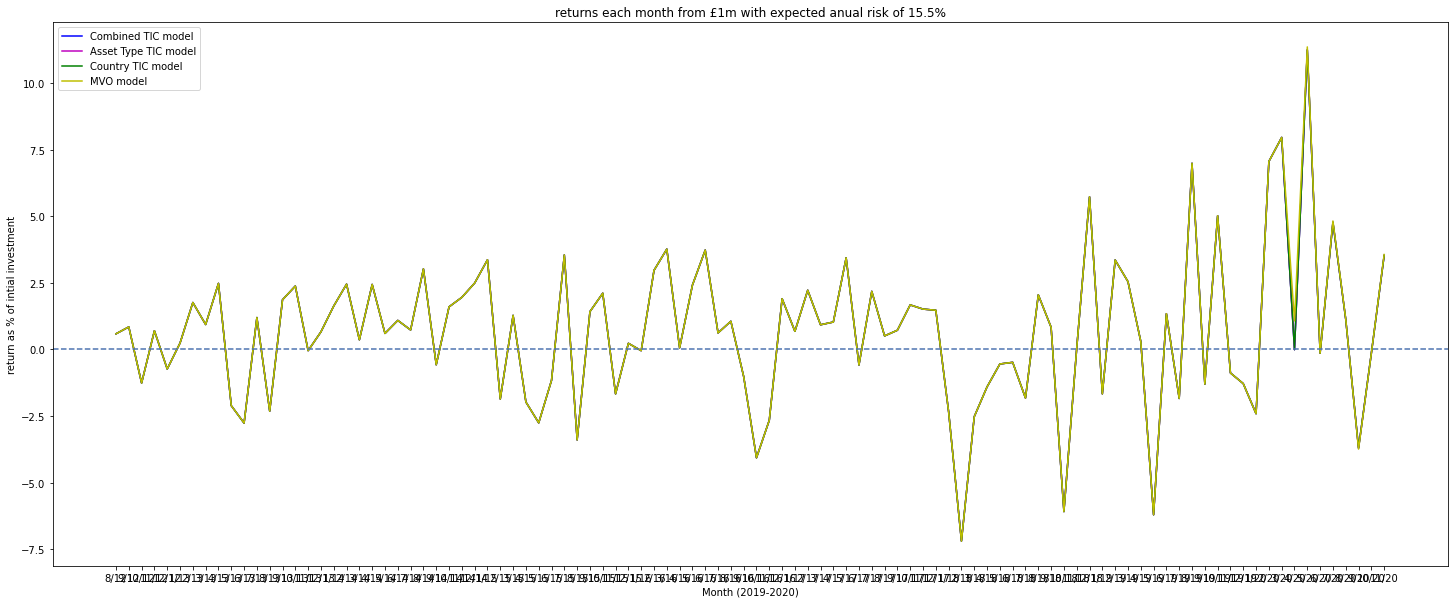

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 10))
line0 = plt.plot(our_month_list,monthly_profits_old0 + monthly_profits0[1:], 'b', label='Combined TIC model')
line1 = plt.plot(our_month_list, monthly_profits_old1 + monthly_profits1[1:], 'm', label='Asset Type TIC model')
line2 = plt.plot(our_month_list, monthly_profits_old2 + monthly_profits2[1:], 'g', label='Country TIC model')
line3 = plt.plot(our_month_list, monthly_profits_old3 + monthly_profits3[1:], 'y', label='MVO model')
plt.title('returns each month from £1m with expected anual risk of 15.5%')
plt.xlabel('Month (2019-2020)')
plt.ylabel('return as % of intial investment')

plt.axhline(0,linestyle = "--")

plt.legend()
plt.show()

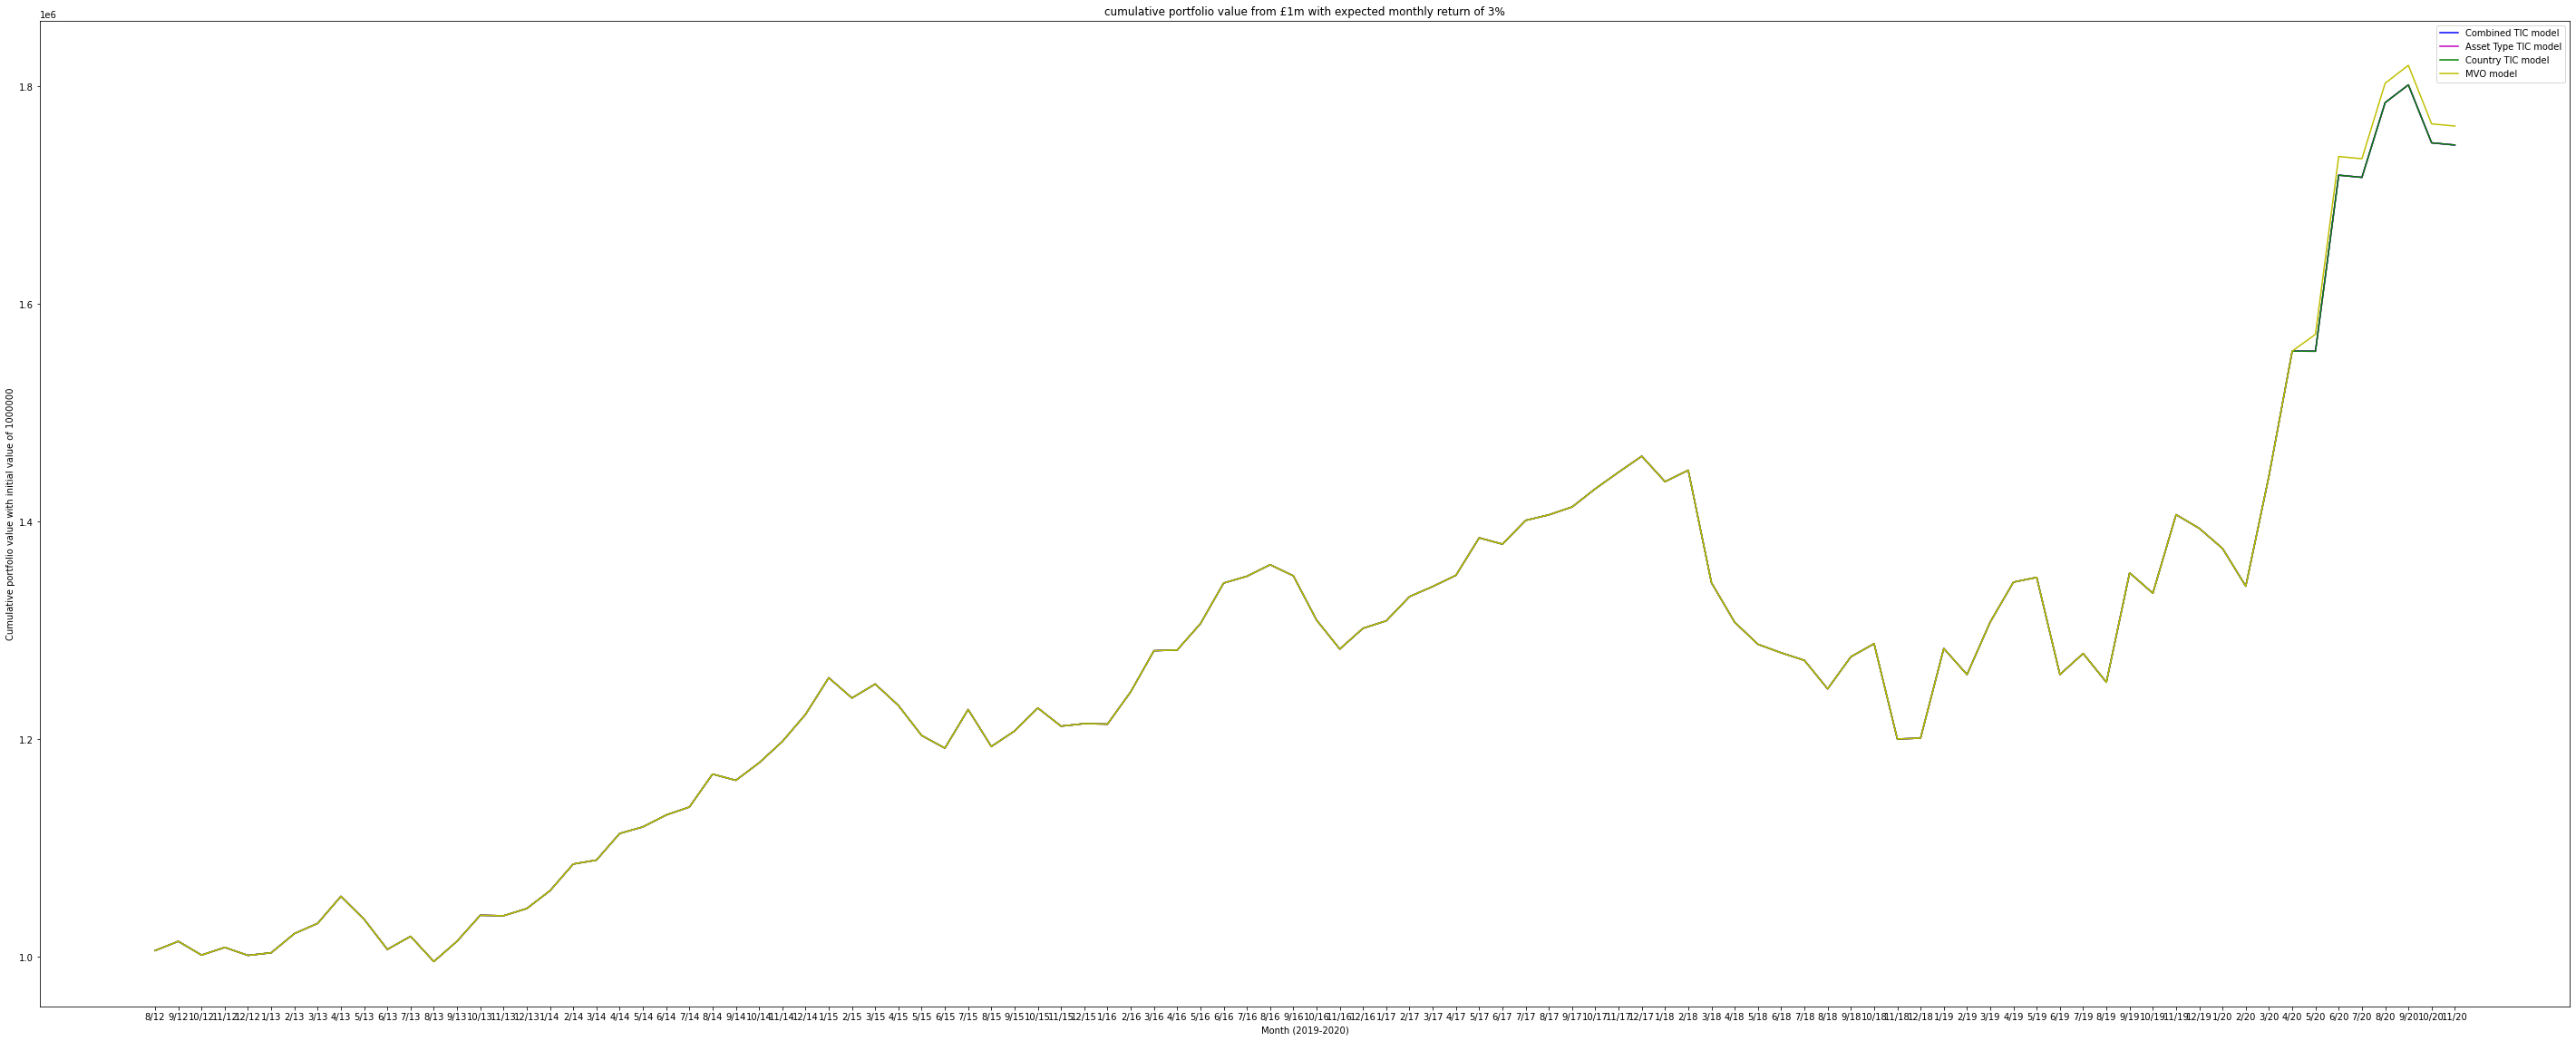

Combined 797069.4936454238
Asset class 797067.7654179821
Country 797071.2218728652
MVO 814991.1847894453


In [23]:

plt.figure(figsize=(50, 20))
line0 = plt.plot(our_month_list, cum_portfolio_value_old0 + cum_portfolio_value0[1:], 'b', label='Combined TIC model')
line1 = plt.plot(our_month_list,cum_portfolio_value_old1 + cum_portfolio_value1[1:], 'm', label='Asset Type TIC model')
line2 = plt.plot(our_month_list, cum_portfolio_value_old2 + cum_portfolio_value2[1:], 'g', label='Country TIC model')
line3 = plt.plot(our_month_list, cum_portfolio_value_old3 + cum_portfolio_value3[1:], 'y', label='MVO model')
#line4 = plt.plot(months_str, diff, 'y', label='MVO model')
plt.title('cumulative portfolio value from £1m with expected monthly return of 3%')
plt.xlabel('Month (2019-2020)')
plt.ylabel('Cumulative portfolio value with initial value of 1000000')



plt.legend()
plt.show()
print("Combined",total_profits_old0 +total_profits0)
print("Asset class",total_profits_old1 + total_profits1)
print("Country",total_profits_old2 +total_profits2)
print("MVO",total_profits_old3 +total_profits3)

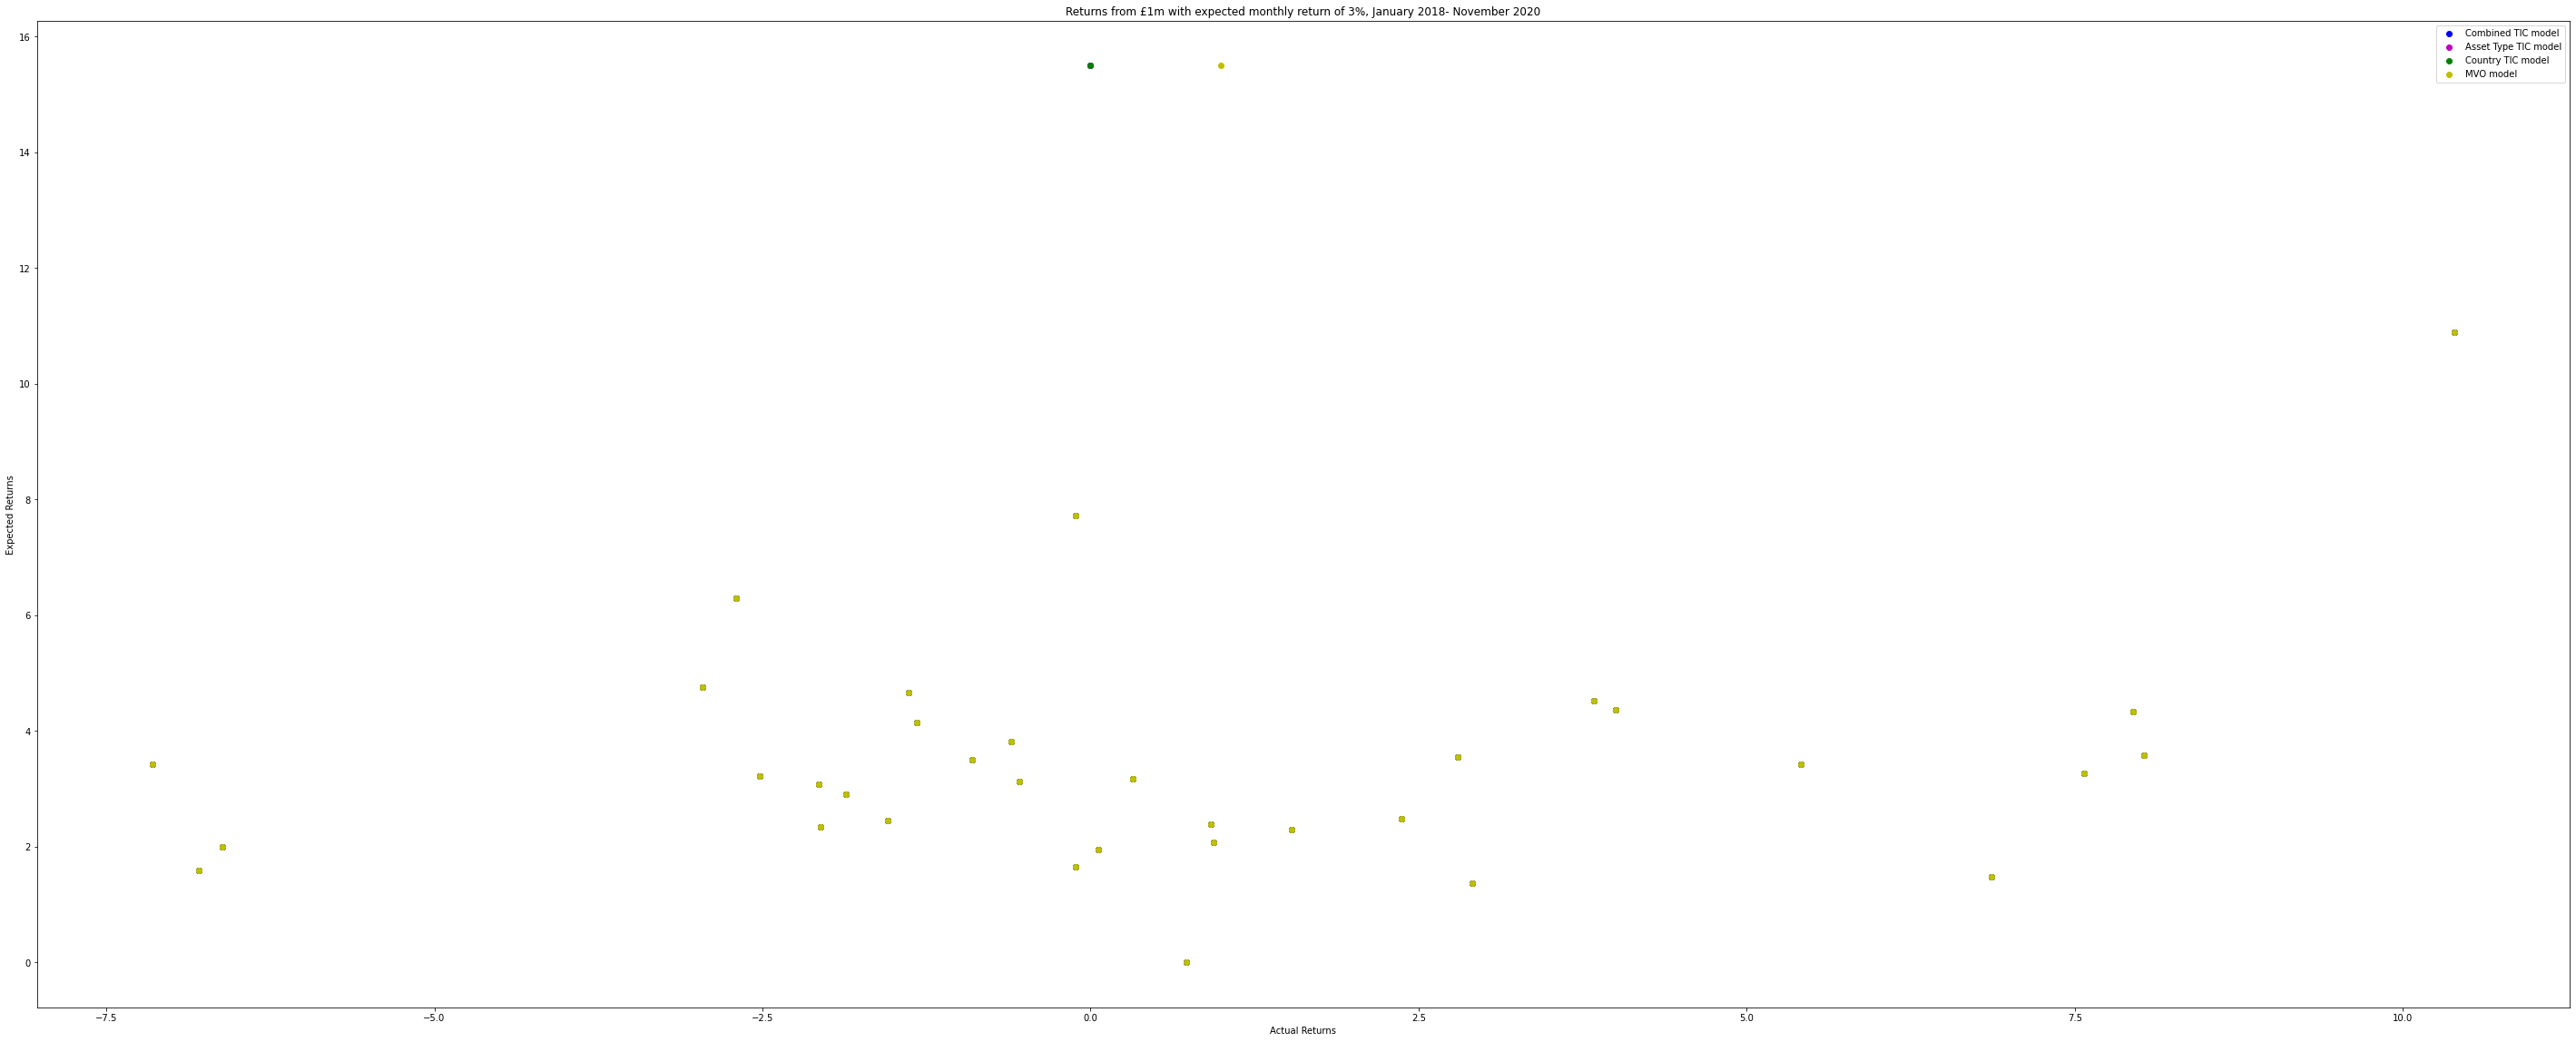

In [24]:
#plotting actual returns against expected returns

plt.figure(figsize=(50, 20))
line0 = plt.scatter(actual_return00, actual_risk00 , c='b', label='Combined TIC model')
line1 = plt.scatter(actual_return11, actual_risk11 , c='m', label='Asset Type TIC model')
line2 = plt.scatter(actual_return22, actual_risk22 , c='g', label='Country TIC model')
line3 = plt.scatter(actual_return33, actual_risk33 , c='y', label='MVO model')
plt.title('Returns from £1m with expected monthly return of 3%, January 2018- November 2020')
plt.xlabel('Actual Returns')
plt.ylabel('Expected Returns')



plt.legend()
plt.show()


In [25]:
j = 1
nb_years2 = 3

year2 = 2018
month_list2 = []
for t in range(0,nb_years2):
    for month in calendar.month_name[1:]:
        a = str(j)+"/" + str(year2)
        month_list2.append(a)
        j = j +1
        
        if j % 13 == 0:
            year2+=1
            j=1
our_month_list2 = month_list2[:-1]


dates2= [datetime.strptime(d,'%m/%Y').date() for d in our_month_list2]


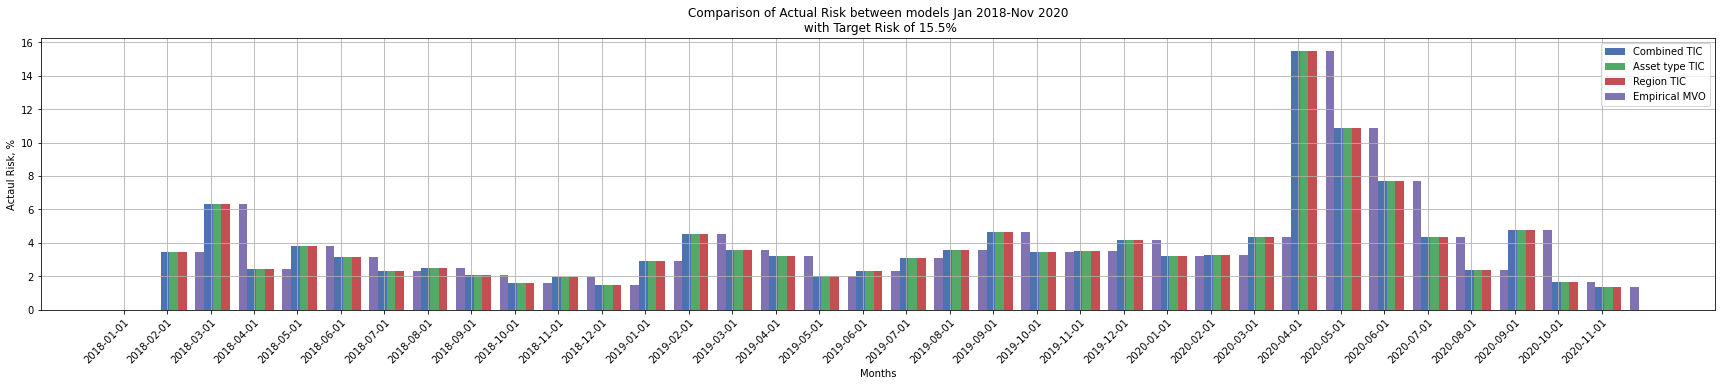

In [29]:
import seaborn as sns

#Making barplot dataframe

columns = ["month", "actual_risk00", "actual_return00",
          "actual_risk11", "actual_return11",
          "actual_risk22", "actual_return22",
          "actual_risk33", "actual_return33",]

list_of_tuples = list(zip(month00, actual_risk00, actual_return00,
          actual_risk11, actual_return11,
          actual_risk22, actual_return22,
          actual_risk33, actual_return33,)) 
box_plot_data = pd.DataFrame(list_of_tuples, columns = columns) 
index = np.arange(len(month00))
bar_width = 0.2



fig, ax = plt.subplots(figsize=((30,5)))
Actual_Returns0 = ax.bar(index, box_plot_data["actual_risk00"], bar_width,
                label="Combined TIC")

Actual_Returns1 = ax.bar(index+0.2, box_plot_data["actual_risk11"],
                 bar_width, label="Asset type TIC")

Actual_Returns2 = ax.bar(index+0.4, box_plot_data["actual_risk22"],
                 bar_width, label="Region TIC")

Actual_Returns3 = ax.bar(index+0.8, box_plot_data["actual_risk33"],
                 bar_width, label="Empirical MVO")

ax.set_xlabel('Months')
ax.set_ylabel('Actaul Risk, %')
ax.set_title('Comparison of Actual Risk between models Jan 2018-Nov 2020\n with Target Risk of 15.5%')
ax.set_xticks(index + bar_width / 4)
ax.set_xticklabels(dates2)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.grid()
ax.legend()

plt.show()

#plot_barplot("actual_risk11", "actual_return11", "Asset Type TIC model")
#plot_barplot("actual_risk22", "actual_return22", "Countries TIC model" )
#plot_barplot("actual_risk33", "actual_return33", "MVO model" )